In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pathlib import Path
from lmfit import Parameters
from lmfit import minimize, fit_report
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
import pyroll.stationary_thermal_analysis_work_roll
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

In [4]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [5]:
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3, \
    finishing_pass_design_4
from in_profile import create_in_profile_for_finishing_train
from utilities import *

In [6]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_moreales(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius


@pr.Roll.specific_heat_capacity
def specific_heat_capacity(self: pr.Roll):
    return 240


@pr.Roll.thermal_conductivity
def thermal_conductivity(self: pr.Roll):
    return 77


@pr.Roll.density
def density(self: pr.Roll):
    return 13.98e3


@pr.Roll.cooling_sections
def cooling_sections(self: pr.Roll):
    return [
        [25, 240]
    ]


@pr.Roll.temperature
def temperature(self: pr.Roll):
    return 50 + 273.15,


In [7]:
in_profile = create_in_profile_for_finishing_train(950 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [8]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd4 = finishing_pass_design_4(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [9]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)
#rolling_train_rpd4.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1397.7488582923372),
    cross_section=Polygon(
        area=5.82635230991946e-05,
        height=0.008700000000000006,
        perimeter=0.027129052642081364,
        width=0.008249205568719213,
        ),
    length=92.57470831110322,
    material=['BST500', 'steel'],
    ring_temperatures=array([1397.74885829, 1395.25908927, 1387.77992574, 1375.26436486,
           1357.5992688 , 1334.64557682, 1306.53190243, 1274.39348479,
           1241.40247337, 1213.15915741, 1195.80201163]),
    strain=np.float64(0.42927981011537364),
    surface_temperature=np.float64(1195.8020116297703),
    t=np.float64(1.8404522472310272),
    temperature=np.float64(1272.4336229716846),
    weight=2400,
    width=np.float64(0.008249205568719213),
    )

In [10]:
sequences = [
    {"label": "RPD1", "sequence": rolling_train_rpd1},
    {"label": "RPD2", "sequence": rolling_train_rpd2},
    {"label": "RPD3", "sequence": rolling_train_rpd3},
    #{"label": "RPD4", "sequence": pass_design_3}
]

In [12]:
def combine_simulated_and_measured_data():
    _data = []

    for entry in sequences:
        groove_label = entry["label"]
        sequence = entry["sequence"]
        roll_passes = sequence.roll_passes
        measurements = extract_wear_contours_from_measurement(groove_label)

        for measurement_id, labels, tonnages, measured_wear_contours in measurements:
            for roll_pass in roll_passes:
                for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                    if roll_pass.label == label:
                        wear_area = calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour)
                        normed_wear_area = wear_area / roll_pass.roll.groove.cross_section.area
                        mean_temperature = (roll_pass.in_profile.temperature + roll_pass.out_profile.temperature) / 2
                        roll_gap_ratio =  roll_pass.roll.contact_area / ((roll_pass.in_profile.cross_section.area + 2 * roll_pass.out_profile.cross_section.area) / 3)
                        if label in ["17-H", "21-H", "23-H", "27-H"]:
                            groove_type = "oval"
                        else:
                            groove_type = "round"
                        _data.append({
                            "groove": groove_label,
                            "measurement_id": measurement_id,
                            "label": label,
                            "groove_type": groove_type,
                            "tonnage": tonnage,
                            "wear_area": wear_area,
                            "normed_wear_area": normed_wear_area,
                            "temperature": mean_temperature,
                            "p_deformation_resistance": np.mean(pillar_deformation_resistance(roll_pass)),
                            "roll_force": roll_pass.roll_force,
                            "roll_temperature_profile": roll_pass.roll.temperature_field,
                            "relative_wear_length": np.max(pillars_wear_length(roll_pass.roll)) / roll_pass.roll.contact_length,
                            "roll_gap_ratio": roll_gap_ratio
                        })

    return _data

In [13]:
data = combine_simulated_and_measured_data()

In [14]:
tonnages = []
normed_wear_areas = []
temperatures = []
deformation_resistances = []
max_roll_surface_temperature =[]
relative_wear_length = []
types = []
roll_gap_ratios = []
for data_per_pass in data:
    roll_surface_temp_arr = np.array(data_per_pass["roll_temperature_profile"].tolist(),dtype=np.float32)
    max_roll_surface_temperature.append(np.max(roll_surface_temp_arr[1]))
    normed_wear_areas.append(data_per_pass['normed_wear_area'])
    tonnages.append(data_per_pass['tonnage'])
    temperatures.append(data_per_pass['temperature'])
    deformation_resistances.append(data_per_pass['p_deformation_resistance'])
    types.append(data_per_pass['groove_type'])
    relative_wear_length.append(data_per_pass['relative_wear_length'])
    roll_gap_ratios.append(data_per_pass['roll_gap_ratio'])


In [17]:
df = pd.DataFrame({
    'tonnage': np.array(tonnages),
    'normed_wear_area': np.array(normed_wear_areas),
    'temperature': np.array(temperatures),
    'deformation_resistance': np.array(deformation_resistances),
    'groove_type': np.array(types),
    'roll_surface_temperature': np.array(max_roll_surface_temperature),
    'relative_wear_length': np.array(relative_wear_length),
    'roll_gap_ratio': np.array(roll_gap_ratios),
    'relative_surface_temperature': np.array(max_roll_surface_temperature) / np.array(temperatures)
})

In [18]:
features_for_clustering = ['tonnage', 'normed_wear_area', 'relative_wear_length', 'roll_gap_ratio', 'relative_surface_temperature']
fitting_array = df[features_for_clustering].values

In [19]:
inertias = []
mapping1 = {}

K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(fitting_array)
    df['cluster'] = kmeanModel.predict(fitting_array)
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = inertias[-1]

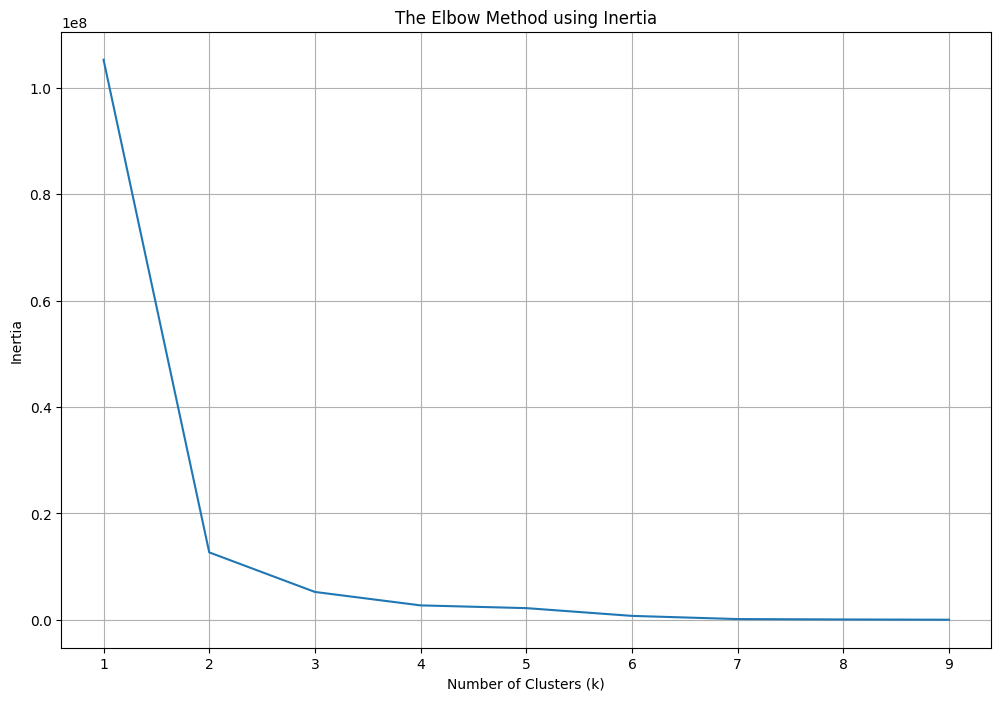

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(True)
ax.set_xlabel('Number of Clusters (k)')
ax.plot(K, inertias, label="Inertia", color="C0")
ax.set_title('The Elbow Method using Inertia')
ax.set_ylabel('Inertia')

fig.savefig(result_dir / "elbow_method_inertia.pdf", bbox_inches='tight', dpi=300)

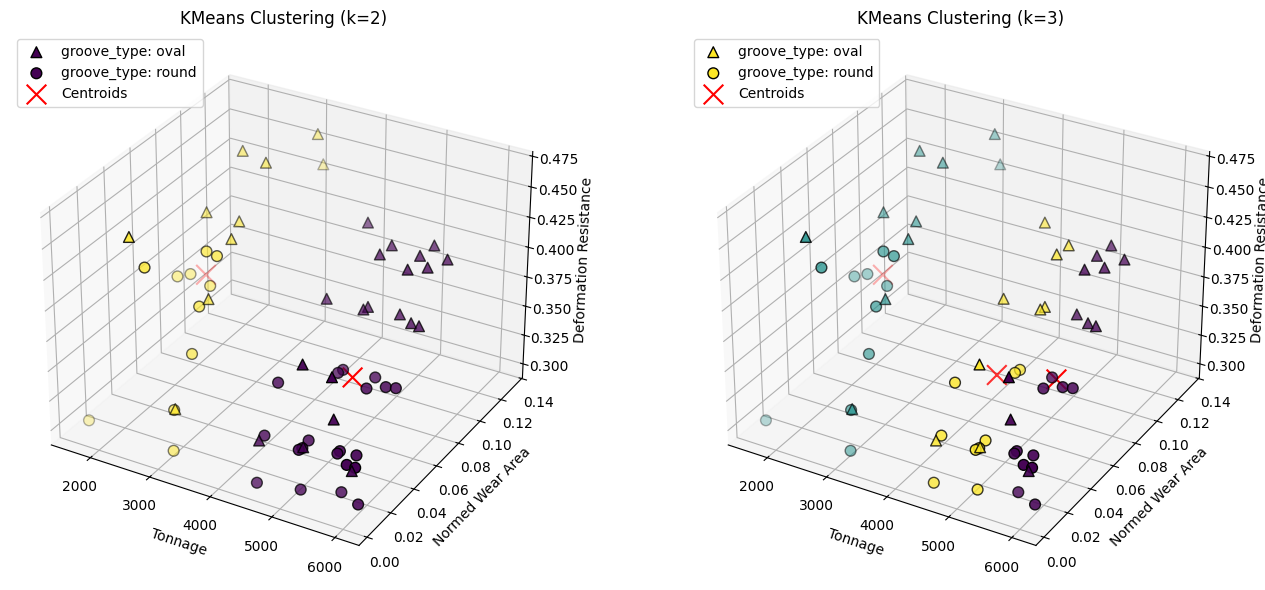

In [27]:
fig = plt.figure(figsize=(14, 6))
tag_to_marker = {'round': 'o', 'oval': '^'}
for idx, k in enumerate([2, 3], 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(fitting_array)

    ax = fig.add_subplot(1, 2, idx, projection='3d')

    for tag in df['groove_type'].unique():
        mask = df['groove_type'] == tag
        ax.scatter(
            df.loc[mask, 'tonnage'],
            df.loc[mask, 'normed_wear_area'],
            df.loc[mask, 'relative_wear_length'],
            c=y_kmeans[mask],
            cmap='viridis',
            marker=tag_to_marker[tag],
            edgecolor='k',
            label=f'groove_type: {tag}',
            s=60
        )

    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        kmeans.cluster_centers_[:, 2],
        c='red', marker='x', s=200, label='Centroids'
    )

    ax.set_title(f'KMeans Clustering (k={k})')
    ax.set_xlabel('Tonnage')
    ax.set_ylabel('Normed Wear Area')
    ax.set_zlabel('Deformation Resistance')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()